# Functional API model : MPVGGNet 

### Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import concatenate, Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, \
    Flatten, Dense
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.models import Sequential

### Instanciate GPU

In [2]:
#use gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


### Process data

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('original data type : ', X_train.dtype)
print('original data range [', np.min(X_train), ',', np.max(X_train), ']')

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print('\nconverted data type : ', X_train.dtype)
print('converted data range [', np.min(X_train), ',', np.max(X_train), ']')

print('\ntraining data shape : ', X_train.shape)
print('testing data shape  : ', X_test.shape)

original data type :  uint8
original data range [ 0 , 255 ]

converted data type :  float32
converted data range [ 0.0 , 1.0 ]

training data shape :  (50000, 32, 32, 3)
testing data shape  :  (10000, 32, 32, 3)


In [4]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


### Create model

In [5]:
input_shape = X_train.shape[1:]

inputs = Input(shape=input_shape)

path1 = inputs
path2 = inputs

for block in range(4):  # 4 blocks
    for layer in range(3):  # 3 Conv2D → relu → BN
        path1 = Conv2D(64, (3, 3), padding='same', strides=1,)(path1)
        path1 = Activation('relu')(path1)
        path1 = BatchNormalization()(path1)
    path1 = MaxPooling2D(pool_size=(2, 2), strides=2)(path1)
    path1 = Dropout(0.3,)(path1)
    

In [6]:
#path2

# First convolutional layer
path2 = Conv2D(64, (3, 3), padding='same')(path2)
activation1 = Activation('relu')(path2)
path2 = MaxPooling2D(pool_size=(4, 4))(path2)
path2 = Conv2D(64, (3, 3), padding='same')(path2)
path2 = Activation('relu')(path2)
path2 = MaxPooling2D(pool_size=(4, 4))(path2)
path2 = Dropout(0.25)(path2)

In [7]:

#concatenate
concatenate = concatenate([path1, path2], axis=-1)

flatten = Flatten(name='flatten')(concatenate)
dense = Dense(256, activation='relu', name='dense_1')(flatten)
dropout = Dropout(0.3, name='dropout_final')(dense)

outputs = Dense(n_classes, activation='softmax', name='outputs')(dropout)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['activation[0][0]']             
 alization)                                                                                   

### Train model

In [8]:
E = 10  # number of epochs
B = 64  # batch size
V = 0.2  # validation split

checkpoint_callback = ModelCheckpoint(
    'best_model_c.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
                verbose=1, validation_data=(X_test, Y_test), callbacks=[checkpoint_callback])

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 1.6712 - accuracy: 0.3882
Epoch 1: val_accuracy improved from -inf to 0.50530, saving model to best_model_c.h5
782/782 [==============================] - 37s 43ms/step - loss: 1.6712 - accuracy: 0.3882 - val_loss: 1.3553 - val_accuracy: 0.5053
Epoch 2/10
781/782 [============================>.] - ETA: 0s - loss: 1.1596 - accuracy: 0.5864
Epoch 2: val_accuracy improved from 0.50530 to 0.62340, saving model to best_model_c.h5
782/782 [==============================] - 69s 88ms/step - loss: 1.1597 - accuracy: 0.5864 - val_loss: 1.0667 - val_accuracy: 0.6234
Epoch 3/10
781/782 [============================>.] - ETA: 0s - loss: 0.9325 - accuracy: 0.6746
Epoch 3: val_accuracy improved from 0.62340 to 0.64100, saving model to best_model_c.h5
782/782 [==============================] - 69s 88ms/step - loss: 0.9324 - accuracy: 0.6746 - val_loss: 1.0505 - val_accuracy: 0.6410
Epoch 4/10
781/782 [============================>.] 

### Evaluate model

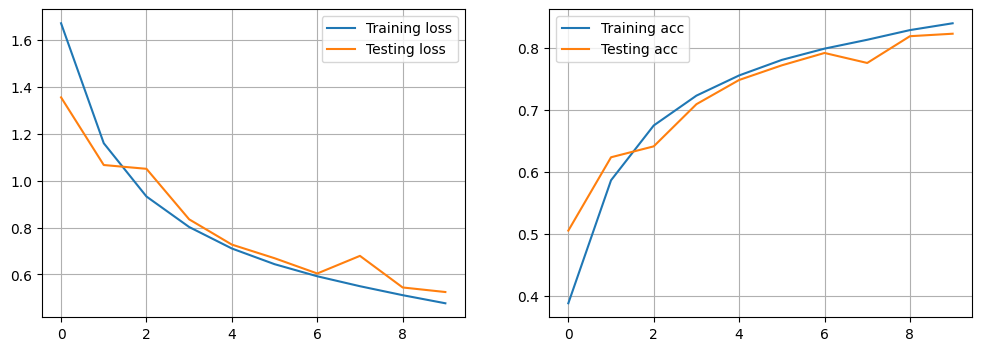

In [9]:
f = plt.figure(figsize=(12, 4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [10]:
train_acc = log.history["accuracy"]
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print(f'Train accuracy : {train_acc[-1]}')
print('Test accuracy:', metric_test)

Train accuracy : 0.8392199873924255
Test accuracy: 0.8223999738693237
